In [1]:
import numpy as np 
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm 
from ISLP import load_data 
from ISLP.models import (ModelSpec as MS, summarize)

# New imports 
from ISLP import confusion_table 
from ISLP.models import contrast 
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 


In [2]:
# Load the Smarket Data
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [3]:
Smarket.drop(columns=['Direction']).corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


In [4]:
# Want to predict whether the stock goes up and down (direction)
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

<Axes: >

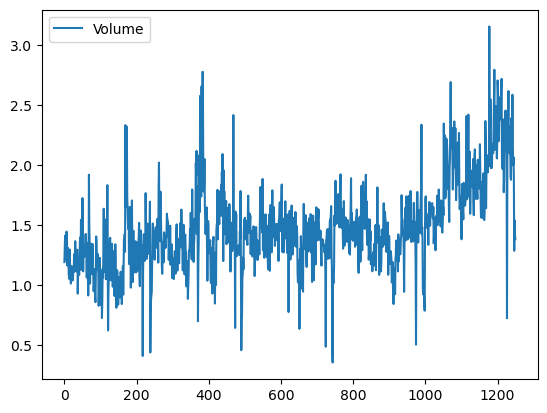

In [5]:
Smarket.plot(y='Volume')

In [6]:
# Running logistic regression 
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
# Using the GLM object from statsmodels
glm = sm.GLM(y, 
             X, 
             family = sm.families.Binomial())
results = glm.fit()
print("The shape of the design matrix:", X.shape)
print("The number of coefficients (including intercept if present):", results.params.shape)
summarize(results)


The shape of the design matrix: (1250, 7)
The number of coefficients (including intercept if present): (7,)


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


Smallest p-values is Lag1. There isn't really any evidence of whether these stocks go up or down. 

In [7]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [8]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [9]:
# The predicted probability that it will go 'up'
probs = results.predict()
print("The shape of the probs prediction:", probs.shape)
probs[:10]

The shape of the probs prediction: (1250,)


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [10]:
# In order to predict whether the market will go up or down on a particular day, convert predicted probs into class labels
# We base the label on predicted probability of a market increase is greater than or less than 0.5 

labels = np.array(['Down']*1250)
labels[probs > 0.5] = 'Up'


# More idiomatic to do the following instead 
print("\nIdiomatic:")
labels_better = np.where(probs > 0.5, 'Up', 'Down')
# Check
np.all(labels_better == labels)





Idiomatic:


True

In [11]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


Off-diagonal represents the incorrect predictions. Therefore, there are 507 + 145 = 652 correct predictions. The fraction of the days that the prediction was correct is:

In [15]:
np.sum(labels == Smarket.Direction)

652

In [24]:
print((507 + 145)/1250, np.mean(labels == Smarket.Direction))

# This is more idiomatic 
print('\nIdiomatic:')
from sklearn.metrics import confusion_matrix
y_true = Smarket.Direction 
y_pred = labels 
# Confusion matrix 
print(confusion_matrix(y_true, y_pred))
# Accuracy 
accuracy = (y_pred == y_true).mean()
print(accuracy)

0.5216 0.5216

Idiomatic:
[[145 457]
 [141 507]]
0.5216


Or 52.2 % of the time. This might show that we are a little better than guessing but we trained and tested the model on the same set of 1,250 observations, and so the training error rate is, 100 - 52.2 = 47.8. As we have seen before, the training error rate is optimistic and tends to underestimate the test error rate. We want to examine how well it predicts held out data. In practice, we are interested in our model's performance not on the data we used to fit the model, but on days in the future for which market movements are unknown. 

In [26]:
# let's split the data into test and training 
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape 

(252, 9)

In [27]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, 
                   X_train, 
                   family = sm.families.Binomial())
results = glm_train.fit()
# Want the predictions on the test data
probs = results.predict(exog=X_test)

In [30]:
# let's compare the predictions for 2005 to the actual movements of the marker over that time period 
D = Smarket.Direction 
L_train, L_test = D.loc[train], D.loc[~train]

In [31]:
labels = np.array(['Down']*252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

# idiomatic 
labels_better = np.where(probs > 0.5, 'Up', 'Down')


In [ ]:
print(np.mean(labels == L_test), np.mean(labels != L_test))

print("\nIdiomatic:")
from sklearn.metrics import confusion_matrix
y_true = L_test
y_pred = labels_better 
# Confusion matrix 
print(confusion_matrix(y_true, y_pred))
# Accuracy 
accuracy = (y_pred == y_true).mean()
error_rate = (y_pred != y_true).mean()
print(accuracy, error_rate)

0.4801587301587302 0.5198412698412699

Idiomatic:
(252,)
(252,)
[[77 34]
 [97 44]]
0.4801587301587302 0.5198412698412699


The test accuracy is about 48% while the error rate is about 52%. 

In [34]:
# Let's try a smaller model and remove variables that appear to not help in predicting Direction. 
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, 
                   X_train, 
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [35]:
(35 + 106)/252, (106)/(76 + 106)

(0.5595238095238095, 0.5824175824175825)

We have calculated the overall accuracy and the accuracy within days when the model predicts an increase.

In [23]:
# Predict returns Direction with particular values of Lag1 and Lag2. Can use predict() function. 
newdata = pd.DataFrame({'Lag1': [1.2, 1.5], 
                        'Lag2': [1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

LDA (Linear discriminant analysis):

In [36]:
# Using the LDA object in Scikit-learn. 
lda = LDA(store_covariance=True)

In [51]:
# The LDA estimator automatically adds an intercept...
# ...so remove the column corresponing to intercept in X_train and X_test
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [52]:
# Let's extract the means in the two classes 
# These are the average of each predictor within each class, mu_k
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

This suggests there is a tendency for the previous 2 days returns on returns to be negative on days when the market increases, and a tendency for the previous day's returns to be positive on days when the market declines. 

In [28]:
# class labels
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [29]:
lda.priors_

array([0.49198397, 0.50801603])

The output above suggests that  and $\hat{\pi}_{\text{down}} = 0.492$ and $\hat{\pi}_{\text{up}} = 0.508$.

In [30]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

These are the multipliers of a linear combination of $\text{Lag1}$ and $\text{Lag2}$, such that they multiply the elements of $X=x$ in (4.24). If $-0.64\times\text{Lag1} - 0.51\times\text{Lag2}$ is large then the LDA classifies will predict a market increase, and if small a decrease.  

In [ ]:
# Having fit on X_train, y_train, we now fit on X_tse
# This gives the predicted class labels for each observation (e.g., 'Up' or 'Down').
# Internally, this is done by computing posterior probabilities and choosing the class with 
# the highest one (i.e., using argmax over predict_proba()).
lda_pred = lda.predict(X_test)
lda_pred.shape

(252,)

As shown below the LDA and logistic regression predictions are almost identical:

In [54]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


We can also estimate the probability of each class for each point in a training set. Applying a 50% threshold to the posterior probs of being class 1 allows us to receat the prediction in *lda_pred*

In [59]:
# the first column is est. prob of class 1 and second est. prob of class 2
lda_prob = lda.predict_proba(X_test)
# This is checking that this is the same as lda_pred (should be)
np.all(
    np.where(lda_prob[:, 1] >= 0.5, 'Up', 'Down') == lda_pred
)

# More idiomatic way 
manual_pred = np.where(lda_prob[:, 1] >= 0.5, lda.classes_[1], lda.classes_[0])
# Check 
np.array_equal(lda_pred, manual_pred)

True

For problems with more than two classes the labels are chosen as the class whose posterior prob is highest:

In [58]:
np.all(
    [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
)

True

In [ ]:
# want to predict a market decrease only if we are certain that market....
# ...will decrease on that day, so posterior prob is at least 90%. 
# the first column of 'lda_prob' coresponds to label 'Down' so use index 0
# lda_prob[:, 0] > 0.9 will output an array of bools that will be True if > 0.9 
np.sum(lda_prob[:, 0] > 0.9)    # sum to get the number of days

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

0

Quadratic Discriminant Analysis:

In [61]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train) 

QuadraticDiscriminantAnalysis(store_covariance=True)

In [62]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

The QDA() classifier will estimate one covariance per class. Here is the estimated covariance in the first class:

In [63]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

This corresponds to 

$$
\Sigma_k = \begin{bmatrix}
\mathrm{Var}(X_1 \mid Y = k) & \mathrm{Cov}(X_1, X_2 \mid Y = k) \\
\mathrm{Cov}(X_2, X_1 \mid Y = k) & \mathrm{Var}(X_2 \mid Y = k)
\end{bmatrix}
$$

since $k=\text{Up},\text{Down}$. 

The output does not contain coefficients of the linear discriminants because the QDA class invilves a quadratic, rather than linear function of predictors. 

In [67]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


Interestingly, QDA predictions are accurate to almost 60% of the time, even though the 2005 data wasn't used to fit the model. 

In [68]:
np.mean(qda_pred == L_test)

0.5992063492063492

This suggest that the quadratic form assumed by QDA may capture the true relationship more accuratley than the linear forms assumed by LDA and logistic regression. However, recomment to evaluate the method's performance on a larger test set before betting that this approach will consistently beat the market. 

Naive Bayes:

In [69]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [70]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [71]:
NB.class_prior_

array([0.49198397, 0.50801603])

The parameters of the features can be found in theta_ and var_ attributes. The number of rows is equal to the number of classes, while the number of columns is squal to the number of features. The mean for feature Lag1 in the Down class is 0.043. 

In [72]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [73]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

As shown above, the variance of Lag1 is 1.503 for Class 0. The variance of Lag1 is 1.514 for Class 1. In Naive Bayes the covariance matrix is diagonal and within class you only have to store variance of each feature rather than covariance. 

In [74]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


Naive Bayes performs well on these data, with accurate predictions over 59% of the time. The is slightly worse than QDA but better than LDA. 

K Nearest Neighbors:

In [64]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


We see the using $K=1$ isn't good since only 50 of the observations are correctly predicted. It might be that $K=1$ results in a overly-flexible fit to the data (overfits the data). 

In [65]:
np.mean(knn1_pred == L_test)

0.5

In [66]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, L_train)
knn3_pred = knn3.predict(X_test)
confusion_table(knn3_pred, L_test)

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [67]:
np.mean(knn3_pred == L_test)

0.5317460317460317

The results have improved slightly, but increasing $K$ futher provides no further improvements. It appears for this data that for the train/test split, QDA gives the best results of the methods we have examined thus far. Let's apply KNN approach to the 'Caravan' data set, which is part of the ISLP library. This data set includes 85 predictors that measure the demographic characteristics for 5,822 individuals. The response variable is $\text{Purchase}$, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set only $6%$ of people purchased insurance. 

In [68]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase 
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

Above shows the counts for each unique element, where $\text{Purchase}$ has only $Yes$ and $No$ elements. 

In [81]:
348 / 5822

0.05977327378907592

In [70]:
# let's use all of features except 'Purchase' 
feature_df = Caravan.drop(columns=['Purchase'])

In [71]:
# we want to scale the units since k nearest neighbors uses distances
# with_mean=True subtracts the mean 
# with_std=True sclases the columns to have a std of 1 
# copy=True means we will copy the data, rather than trying to do calculations in place where possible
scaler = StandardScaler(with_mean=True, 
                        with_std=True, 
                        copy=True)

In [72]:
# apply the transformation to the features
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [73]:
feature_std = pd.DataFrame(
                X_std, 
                columns=feature_df.columns); 
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [74]:
(X_train, 
 X_test, 
 y_train, 
 y_test) = train_test_split(feature_std, 
                            Purchase, 
                            test_size=1000, 
                            random_state=0)

In [75]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")


(0.111, 0.067)

The KNN error rate on the $1,000$ test observation is about $11$. At first, this may appear to be good but just over 6% of customers purchased insurance, so we can get the error rate down to almost 6% by always predicting $No$ regardless of the values of the predictors. This is called the *null rate*. 

In [82]:
# Tuning parameters 
for K in range(1, 6): 
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)   # rows predicted, columns actual
    templ = ('K={0:d}: # predicted to rent: {1:>2},'+
             '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes', 'Yes']
    print(templ.format(
          K, 
          pred, 
          did_rent, 
          did_rent/pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


In [83]:
print(C)
# Gives you the predicted 'Yes'
print(C.loc['Yes'])
# Gives you the actual 'Yes
print(C['Yes'])

Truth       No  Yes
Predicted          
No         927   66
Yes          6    1
Truth
No     6
Yes    1
Name: Yes, dtype: int64
Predicted
No     66
Yes     1
Name: Yes, dtype: int64


In [80]:
# More idiomatic 
for K in range(1, 6): 
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)

    # true vs predicted
    C = confusion_table(y_test, knn_pred)  # if rows = actual, columns = predicted

    predicted_yes = C['Yes'].sum()
    true_positive = C.loc['Yes', 'Yes']
    
    accuracy = true_positive / predicted_yes if predicted_yes > 0 else 0

    print(f"K={K}: # predicted to rent: {predicted_yes:>2},"
          f"  # who did rent {true_positive}, accuracy {accuracy:.1%}")


K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


In [84]:
# We can also fit a logistic regression model to the data. 
# If you don't set C to a large number, then it's a regularized version of logistic regression
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:, 1] > 0.5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,931,67
Yes,2,0


Only two of the test observations predicted a purchase for the insurance. If we use 
a different predicted probability threshold, like 0.25, then we predict 29 people will 
purchase insurance and we are correct for about 31% of these people. This is 5
times better than random guessing. 

In [85]:
logit_labels = np.where(logit_pred[:, 1] > 0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [86]:
accuracy = 9/(20 + 9)
accuracy

0.3103448275862069

Linear and Poission Regression on Bikeshare Data: 

**bikers** measures the number of bike rentals per hour in Washington DC in the period 2010 - 2012. 

In [87]:
bike = load_data('Bikeshare')

In [88]:
bike.shape, bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [89]:
# Fit linear regression model to data 
X = MS(['mnth', 
        'hr', 
        'workingday', 
        'temp', 
        'weathersit']).fit_transform(bike)
y = bike['bikers']
model_lm = sm.OLS(y, X).fit()
summarize(model_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


There are 24 levels in hr and 40 rows in all. The first levels hr[0] and mnth[Jan] are treated as the baseline values and so no coefficient estimates are provided for them. Implicitly their coeffiecients are zero and all the other levels are measured relative to those baselines. For example, the Feb coefficient of 6.845  signifies that, holding all other variables constant, there are on average about 7 more riders in Feb than in Jan. Similarily there are about 16.5 more riders in March than Jan. 

Let's try a slightly different coding. 

In [90]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [93]:
# Refit with new encoding 
X2 = MS([mnth_encode, 
         hr_encode, 
         'workingday', 
         'temp', 
         'weathersit']).fit_transform(bike)
model2_lm = sm.OLS(y, X2).fit()
s2 = summarize(model2_lm)
s2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In `model2_lm`, a coefficient estimate is reported for all but level `23` of `hr`
and level `Dec` of `mnth`. Importantly, in `model2_lm`, the (unreported) coefficient estimate
for the last level of `mnth` is not zero: instead, it equals the
negative of the sum of the coefficient estimates for all of the
other levels. Similarly, in `model2_lm`, the coefficient estimate
for the last level of `hr` is the negative of the sum of the
coefficient estimates for all of the other levels. This means that the
coefficients of `hr` and `mnth` in `model2_lm` will always sum
to zero, and can be interpreted as the difference from the mean
level. For example, the coefficient for January of $-46.087$ indicates
that, holding all other variables constant, there are typically 46
fewer riders in January relative to the yearly average.

It is important to realize that the choice of coding really does not
matter, provided that we interpret the  model output correctly in light
of the coding used. For example, we see that the predictions from the
linear model are the same regardless of coding:

In [94]:
# sum of squared difference between the fits of the different encodings
np.sum((model_lm.fittedvalues - model2_lm.fittedvalues)**2)

5.006155854534554e-20

In [95]:
# can also use 
np.allclose(model_lm.fittedvalues, model2_lm.fittedvalues)

True

In [107]:
# obtain coefficient estimates for each month and plot it 
# extract coefficients of all months except Dec 
coef_month = s2[s2.index.str.contains('mnth')]['coef']
print(coef_month)

# More idiomatic
coef_month_i = s2.loc[s2.index.str.contains('mnth'), 'coef']


mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64


In [101]:
# next append Dec as negative of the sum of all other months (it's the baseline)
months = bike['mnth'].dtype.categories
coef_month = pd.concat([
                       coef_month,
                       pd.Series([-coef_month.sum()],
                                  index=['mnth[Dec]'
                                 ])
                       ])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

In [ ]:
# More idiomatic of above
months = bike['mnth'].dtype.categories
# Compute Dec coefficient 
dec_coeff = -coef_month_i.sum()
# Append Dec to coefficient series 
coef_month_i = pd.concat([
                         coef_month_i,
                         pd.Series([dec_coeff], index=['mnth[Dec]'])
])
print(coef_month_i)
# if not, reorder by calendar month
coef_month_i = coef_month_i.reindex([f'mnth[{m}]' for m in months])
print(coef_month_i)

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64
mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64


Text(0, 0.5, 'Coefficient')

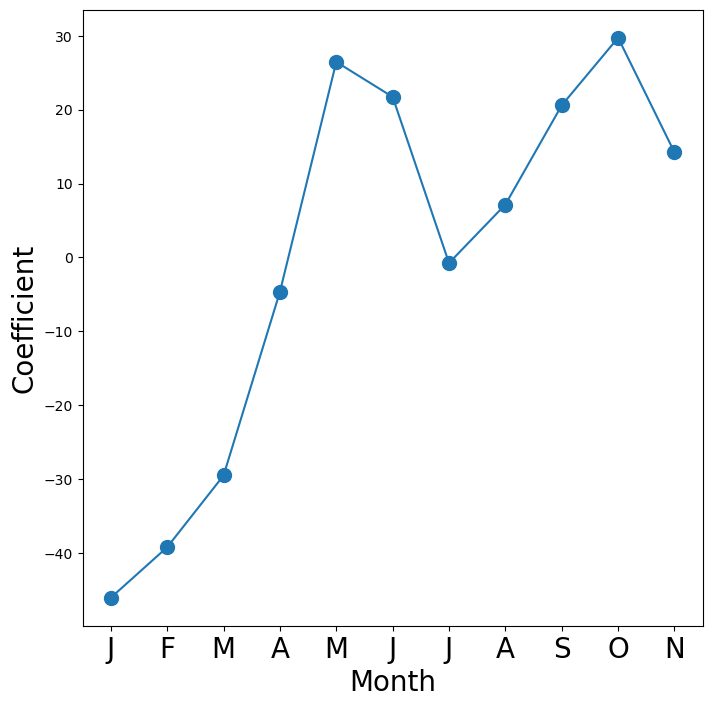

In [ ]:
# Use first letter of each month as x-tick label 
fig_month, ax_month = subplots(figsize=(8, 8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)


In [ ]:
# This is works even if the index format changes to 'mnth[January]', more robust
[label.split('[')[1][0] for label in coef_month.index]

['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

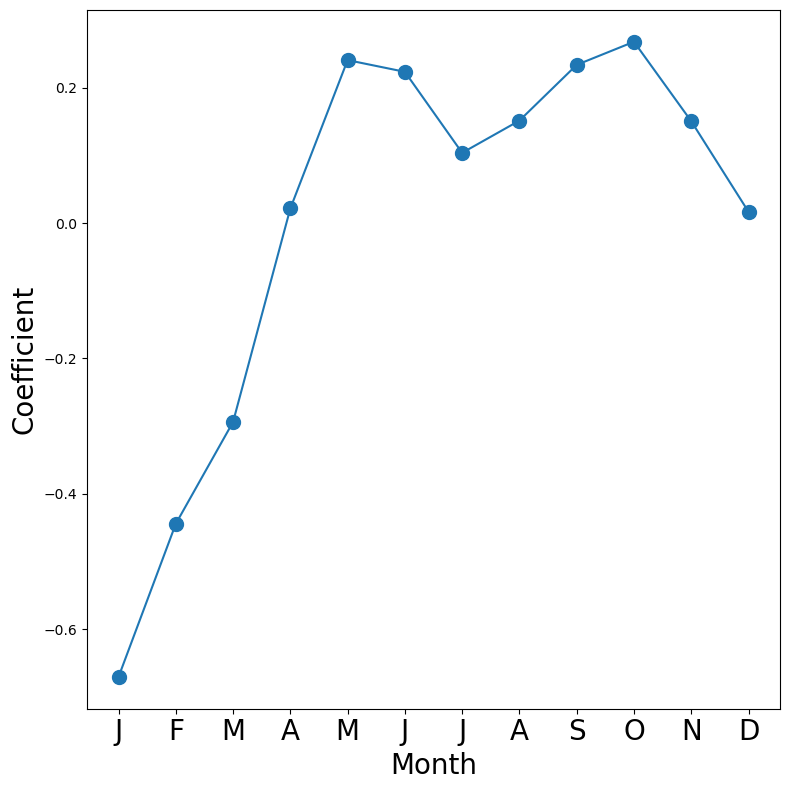

In [147]:
# More idiomatic 
import matplotlib.pyplot as plt
fig_month, ax_month = plt.subplots(figsize=(8, 8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month.values, marker='o', ms=10)
ax_month.set_xticks(x_month)
month_labels = [label.split('[')[1][0] for label in coef_month.index]
ax_month.set_xticklabels(month_labels, fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
plt.tight_layout()
plt.show()

In [114]:
coef_hr = s2[s2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()], index=['hr[23]'])
                    ])


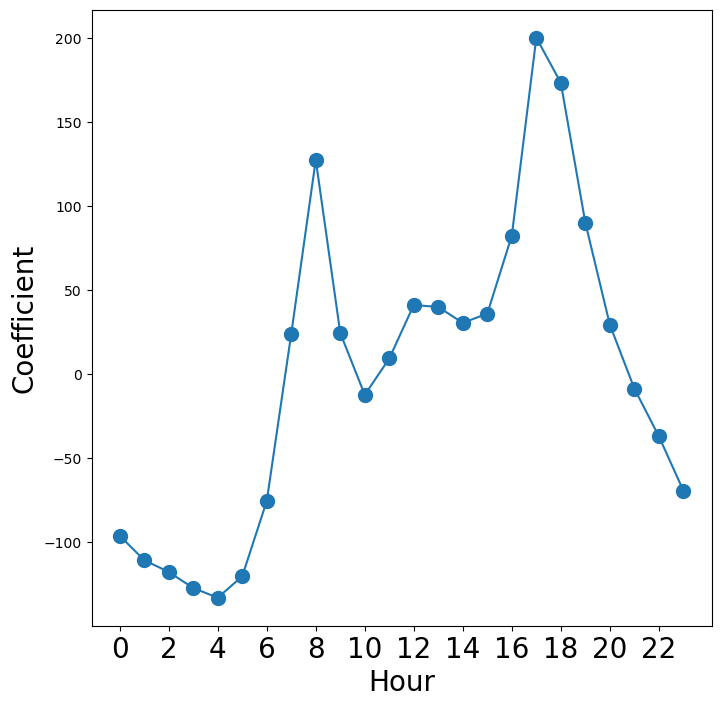

In [116]:
fig_hr, ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);


In [117]:
# fit using Poisson regression 
model_pois = sm.GLM(y, X2, family=sm.families.Poisson()).fit()

In [ ]:
s_pois = summarize(model_pois)
coef_month_p = s_pois[s_pois.index.str.contains('mnth')]['coef']
coef_month_p = pd.concat([coef_month_p,
                        pd.Series([-coef_month_p.sum()],
                                   index=['mnth[Dec]'])])
coef_hr_p = s_pois[s_pois.index.str.contains('hr')]['coef']
coef_hr_p = pd.concat([coef_hr_p,
                     pd.Series([-coef_hr_p.sum()],
                     index=['hr[23]'])])

coef_month_p.shape, x_month.shape


((12,), (11,))

/var/folders/cq/40v2gwt15011mxywd0zkdwjh0000gn/T/ipykernel_38004/4079505018.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels(range(24)[::2], fontsize=20)


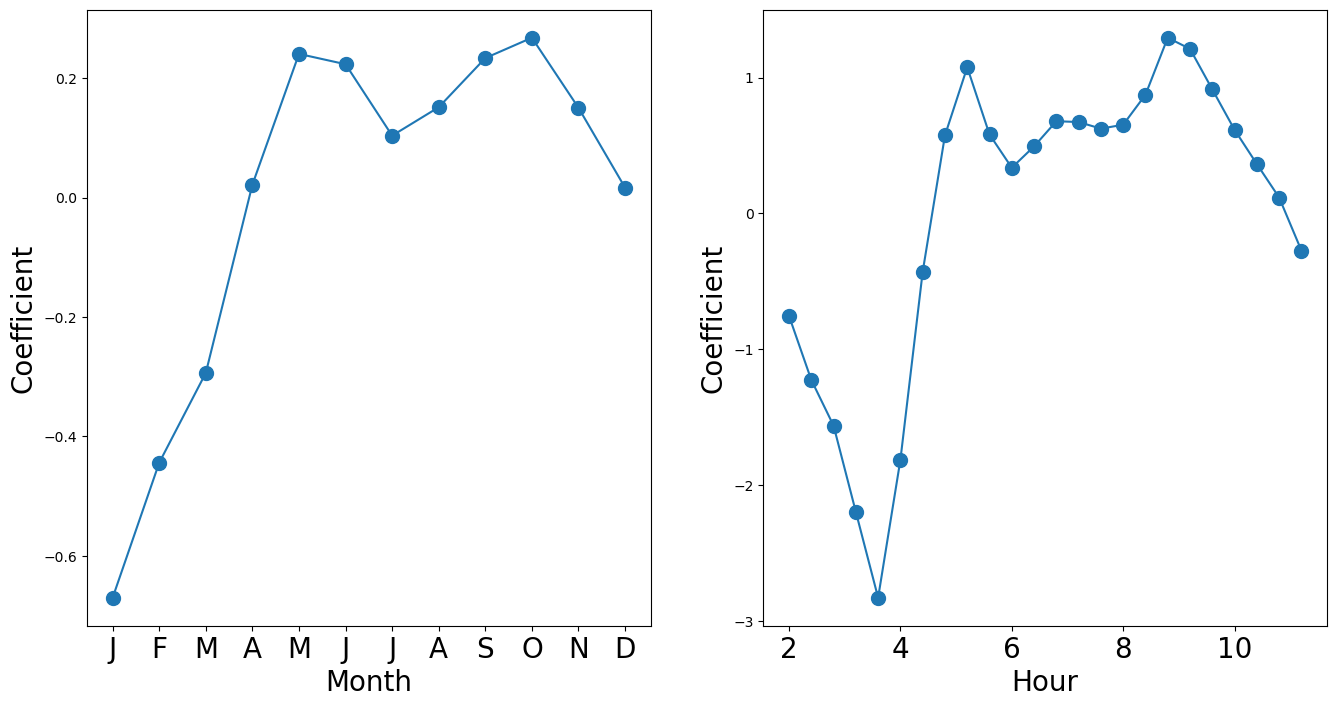

In [130]:
fig_pois, (ax_month, ax_hr) = subplots(1, 2, figsize=(16,8))
x_month = np.arange(coef_month_p.shape[0])
ax_month.plot(x_month, coef_month_p, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr, coef_hr_p, marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

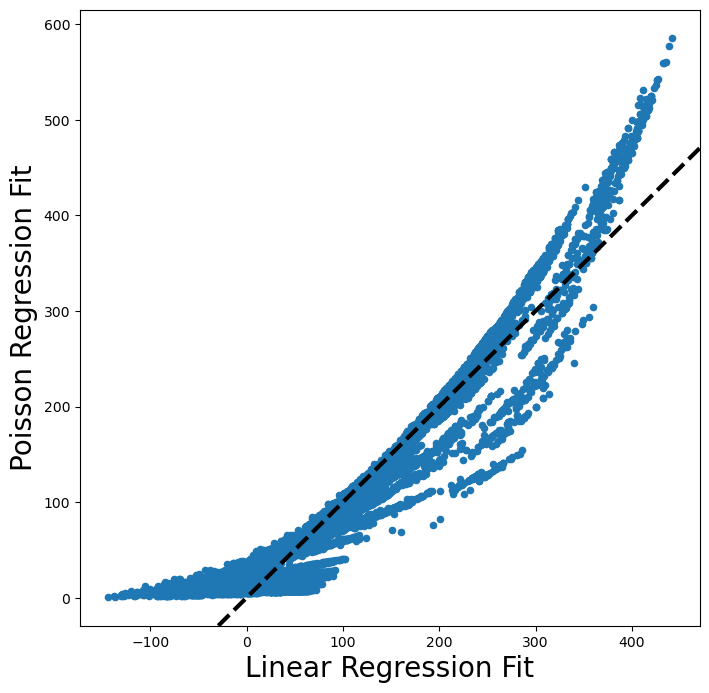

In [ ]:
# Compare the fitted values of the two models
fig, ax = subplots(figsize=(8, 8))
ax.scatter(model2_lm.fittedvalues, 
           model_pois.fittedvalues, 
           s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0, 0], c='black', linewidth=3, 
          linestyle='--', slope=1);

The predictions from the Poisson regression model are correlated with the linear model, but the former are non-negative. Therefore, Poisson regression predictions tend to be larger than those for the linear mode for either very low or very high levels of ridership. 